<a href="https://colab.research.google.com/github//vlamen/tue-deeplearning/blob/main/tutorials/P5.3_VAE_additional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Additional material on VAEs
Although the information in `P5.3_VAE.ipynb` is correct and useful, and manually implementing the reparameterization trick is good for educational purposes, modern Pytorch allows for easier and more flexible ways of implementing Variational Auto Encoders. We shall delve into this in this additional tutorial and also look at some useful tricks for training VAEs.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import distributions as D  # we'll use this for implementing our VAE easily
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

In [2]:
# get data
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

In [3]:
[tensor.shape for tensor in next(iter(train_loader))]

[torch.Size([100, 1, 28, 28]), torch.Size([100])]

The distributions in torch.distributions allow us to parameterize many commonly used probability distributions. For example, we can parameterize a normal distribution with mean `mu = torch.zeros(20, 10)` and *standard deviation* `sigma = torch.ones_like(mu)` as `normal_distribution = D.Normal(loc=mu, scale=sigma)`.
These objects already implement the reparameterization trick for us as `rsample` and the log-likelihood function as `log_prob`. 

This allows us to write a VAE in a high level way as follows:

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size:int, encoder:nn.Module, decoder:nn.Module):
        """
        :param latent_size: dimension of the latent space
        :param encoder: an nn.Module that takes in data, x, and returns a D.Distribution instance representing q(z|x)
        :param decoder: an nn.Module that takes in latent codes, z, and returns a D.Distributino instance representing p(x|z)
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_size = latent_size

        self._init_prior()
         
    def _init_prior(self):
        # for simplicity, let's stick with a standard normal distribution as a prior
        self.register_buffer('prior_loc', torch.zeros(self.latent_size))
        self.register_buffer('prior_scale', torch.ones(self.latent_size))
        # using buffers makes sure that these are moved to the same device the rest of the network is on
        # if we'd want the location and scale of the prior to be learned, we could use nn.Parameter instead of buffers, 
        # although we would have to make sure the scale is always positive
        # alternatively we could add a prior:nn.Module argument to the __init__ for even more freedom

    @property
    def prior(self)->D.Distribution:
        # torch.distributions works with two kinds of shapes: batch_shape and event_shape
        # although for this example, it is not strictly necessary, it can in general be useful to make sure that your dimensions are part of the correct shape
        # Here, we use D.Independent to make the latent dimensions part of the event shape
        # NB the 1 means that one dimension at the end of the batch_shape becomes a part of the event_shape instead
        return D.Independent(D.Normal(loc=self.prior_loc, scale=self.prior_scale), 1)

    def forward(self, x: torch.Tensor) -> tuple[D.Distribution, D.Distribution, torch.Tensor]:
        """ 
        To keep the forward pass of our model somewhat similar to the VAE class in `P5.3_VAE.ipynb`, we return the decoding distribution, encoding distribution and latent code
        
        :param x: batch of data
        :return: p(x|z), q(z|x), z
        """
        encoding_distribution = self.encoder(x)  # q(z|x)
        z = encoding_distribution.rsample()  # NB use rsample for reparameterization trick
        decoding_distribution = self.decoder(z)  # p(x|z)

        return decoding_distribution, encoding_distribution, z # p(x|z), q(z|x), z

    def compute_losses(self, x, decoding_distribution, encoding_distribution, z) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the Kullback Leibler Divergence and the reconstruction loss
        :param x: batch of data
        :param decoding_distribution: p(x|z)
        :param encoding_distribution: q(z|x)
        :param z: sample from q(z|x) used for p(x|z)
        :return: reconstruction_loss, dkl
        """

        dkl = encoding_distribution.log_prob(z).mean(0).sum() - self.prior.log_prob(z).mean(0)  # mean over batch, sum over anything else
        # here we don't make use of the analytic expression of the dkl between two gaussians
        # instead we use the generic Stochastic Gradient Variational Bayes estimator \tilde{\mathcal{L}}^A from the Auto-Encoding Variational Bayes paper
        # the drawback of this is that this only gives an approximation of the dkl
        # the advantage is that it is much more flexible: 
        #     we are not assuming the encoding distribution is a normal distribution with diagonal covariance matrix
        #     and if we want to use a different prior, this would require minimal code changes

        # note that the sum method in our example shouldn't do anything for the encoder in this notebook
        # however, it can be useful to build in a safeguard against bugs stemming from event_shape vs batch_shape mixups
        # a maybe better safeguard against it would be to check if the event_shape is non-scalar, and if it is a scalar, to call D.Independent on the encoding distribution

        reconstruction_loss = -decoding_distribution.log_prob(x).mean(0).sum()  # mean over batch, sum over anything else

        return reconstruction_loss, dkl
    
    def encode(self, x: torch.Tensor)->torch.Tensor:
        """encode method for encoding data

        :param x: batch of datapoints
        :return: latent representations of said batch
        """
        encoding_distribution: D.Distribution = self.encoder(x)
        return encoding_distribution.rsample() 
    
    def sample(self, num_samples:int, take_mean:bool=True) -> Union[torch.Tensor, D.Distribution]:
        z = self.prior.sample((num_samples,))
        decoding_distribution: D.Normal = self.decoder(z)

        if take_mean:
            # often instead of sampling from the decoding distribution, we just want to take its mean
            # note that under the assumption that the decoding distribution is normal, sampling from it 
            # would correspond to taking the mean and adding Gaussian noise to that mean
            return decoding_distribution.loc  
        return decoding_distribution.sample()
    
    def auto_encode(self, x:torch.Tensor, take_mean:bool=True)->Union[torch.Tensor, D.Distribution]:
        decoding_distribution, _, _ = self(x)
        if take_mean:
            return decoding_distribution.loc 
        return decoding_distribution.sample()
        

Let's now see what changes we need to make to the encoder and decoder code from before.

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_pre_scale = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # we'll do the flattening in the encoder model instead of in the training loop
        # this makes it easier to swap out the Encoder for e.g. a convolutional architecture if we want to do so
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        pre_scale = self.fc_pre_scale(h)
        scale = F.softplus(pre_scale)
        # the scale of the distribution needs to be positive
        # one way to accomplish this, as shown in the previous tutorial, is to parameterize the logarithm of the scale (log_sigma)
        # this was useful because we needed log_sigma for the analytical expression for the Dkl
        # however, to get the scale, we then need to take the exponential of log_sigma, which can blow up quite rapidly
        # using a softplus activation instead can be numerically more stable since it is (approximately) linear for large inputs

        encoding_distribution = D.MultivariateNormal(loc=mu, scale_tril=torch.diag_embed(scale))
        # note that to use a different family of distributions for the encoder, we wouldn't need to change anything about the VAE class or the loss function
        return encoding_distribution
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_shape=(1, 28, 28), scale=1/np.sqrt(2)):
        """ 
        :param latent_dim: dimensionality of the latent space
        :param hidden_dim: size of hidden layers
        :param output_shape: shape that the output should have (excluding batch dimension) 
        :param scale: scale of the output distribution. 
            as explained in the previous notebook, because we're using a normal distribution,
            this is essentially a factor for the mean squared error. 
        """
        super(Decoder, self).__init__()

        self.output_shape = tuple(output_shape)
        output_dim = np.prod(output_shape)

        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
        self.register_buffer('scale', torch.as_tensor(scale, dtype=torch.float32))
        
    def forward(self, z):
        batch_size = z.shape[0]
        h = torch.relu(self.fc_hidden1(z))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h)).view(
            (batch_size,)+self.output_shape
            )
        
        return D.Normal(loc=x_reconstr, scale=self.scale)
    

In [6]:
x_dim  = 784
hidden_dim = 500
latent_dim = 12

vae = VAE(
    latent_dim,
    Encoder(x_dim, hidden_dim, latent_dim),
    Decoder(latent_dim, hidden_dim, (1, 28, 28))
)

In [7]:
lr = 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

epochs = 50
vae.train()

n_batches = len(train_loader)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')

vae.to(device=device)

print("Start training")
for epoch in range(1, epochs+1):
    total_loss = 0
    total_rec = 0
    total_dkl = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        rec, dkl = vae.compute_losses(batch, *vae(batch))

        loss = rec + dkl 
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_dkl += dkl.item()
        total_rec += rec.item()
    avg_loss = total_loss / n_batches
    avg_dkl = total_dkl / n_batches 
    avg_rec = total_rec / n_batches
    print(f"Finished epoch {epoch} / {epochs}.\t Average loss: {avg_loss:.4f}\t Average reconstruction loss: {avg_rec:.4f}\t Average Dkl: {avg_dkl:.4f}")
print("Finished training")
vae.to(cpu)

del batch 


Start training
Finished epoch 1 / 50.	 Average loss: 493.8978	 Average reconstruction loss: 490.0230	 Average Dkl: 3.8748
Finished epoch 2 / 50.	 Average loss: 483.2348	 Average reconstruction loss: 476.1623	 Average Dkl: 7.0725
Finished epoch 3 / 50.	 Average loss: 481.1656	 Average reconstruction loss: 473.1541	 Average Dkl: 8.0115
Finished epoch 4 / 50.	 Average loss: 479.9808	 Average reconstruction loss: 471.5020	 Average Dkl: 8.4788
Finished epoch 5 / 50.	 Average loss: 479.3047	 Average reconstruction loss: 470.5733	 Average Dkl: 8.7314
Finished epoch 6 / 50.	 Average loss: 478.8333	 Average reconstruction loss: 469.9276	 Average Dkl: 8.9056
Finished epoch 7 / 50.	 Average loss: 478.4577	 Average reconstruction loss: 469.4145	 Average Dkl: 9.0432
Finished epoch 8 / 50.	 Average loss: 478.1953	 Average reconstruction loss: 469.0565	 Average Dkl: 9.1388
Finished epoch 9 / 50.	 Average loss: 477.9609	 Average reconstruction loss: 468.7339	 Average Dkl: 9.2271
Finished epoch 10 / 50

# About the reconstruction loss
In light of the previous tutorial, our reconstruction loss seems rather high. Why is this?
Well, remember that for the loss function in `P5.3_VAE.ipynb`, we didn't use the actual log-likelihood of the decoding distribution, but only used the non-constant part.
Our reconstruction loss here is the mean squared error *plus* this constant, which is $\frac{28*28}{2} \cdot (\log(2\pi) + \log(1/2)) \approx 448.7341$.
We can check this: 

In [8]:
vae.eval()
batch, _ = next(iter(train_loader))
dec_dist = vae(batch)[0]
reconstruction = dec_dist.loc 

(-dec_dist.log_prob(batch).mean(0).sum()) - torch.square(reconstruction - batch).mean(0).sum()

tensor(448.7341, grad_fn=<SubBackward0>)

In [9]:
torch.square(reconstruction - batch).mean(0).sum()

tensor(17.4010, grad_fn=<SumBackward0>)

Let's look at the reconstructions and samples from the model and investigate the latent space

In [10]:
originals = []
reconstructions = []
codes = []
labels = []

vae.eval()
vae.to(device=device)
with torch.no_grad():
    for batch, y in test_loader:
        originals.append(batch.detach())
        labels.append(y)
        batch = batch.to(device)
        dec, enc, _ = vae(batch)
        
        reconstructions.append(dec.loc.detach().cpu())
        codes.append(enc.loc.detach().cpu())
vae.to(device=cpu)
        

VAE(
  (encoder): Encoder(
    (fc_input): Linear(in_features=784, out_features=500, bias=True)
    (fc_hidden): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=12, bias=True)
    (fc_pre_scale): Linear(in_features=500, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc_hidden1): Linear(in_features=12, out_features=500, bias=True)
    (fc_hidden2): Linear(in_features=500, out_features=500, bias=True)
    (fc_output): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [11]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 28, 28)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')



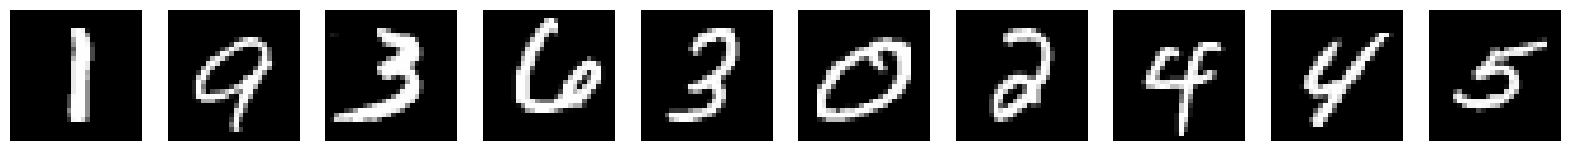

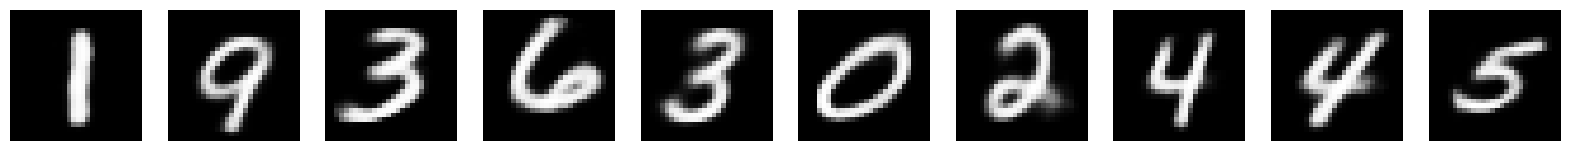

In [12]:
batch_idx = 0
show_images(originals[batch_idx])
show_images(reconstructions[batch_idx])

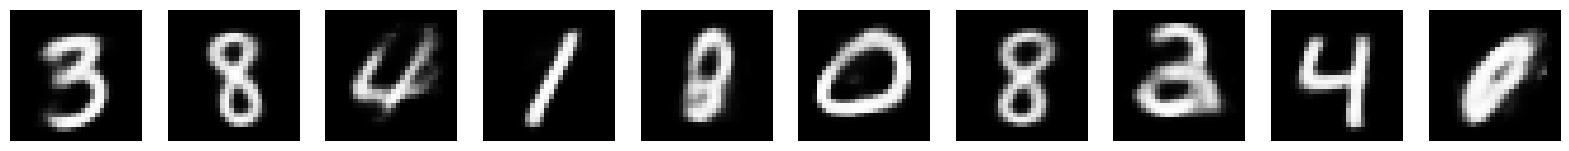

In [13]:
with torch.no_grad():
    show_images(vae.sample(10))

Because we have a latent space that is higher than two dimensional, we can't just plot the latent codes directly. However, using a tSNE embedding, we can still get an impression of what the latent space looks like:

In [14]:
from sklearn.manifold import TSNE
with torch.no_grad():
    all_codes = torch.cat(codes, 0).numpy()
    labels = torch.cat(labels, 0).numpy()

all_codes_embedded = TSNE(n_components=2).fit_transform(all_codes)

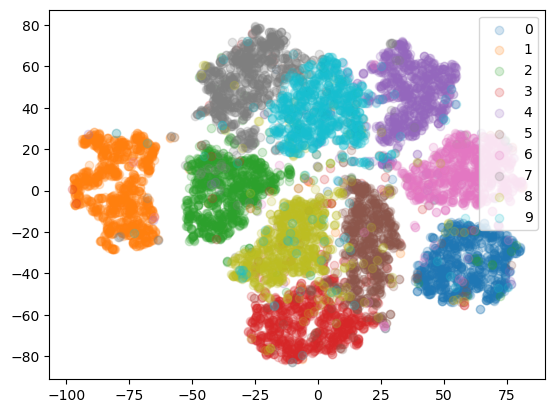

In [15]:
for label in range(10):
    embedded_codes_for_label = all_codes_embedded[labels==label]
    plt.scatter(embedded_codes_for_label[:, 0], embedded_codes_for_label[:, 1], alpha=.2, label=label)
plt.legend()
plt.show()

As we can see, it looks like the VAE has done a decent job at clustering the different codes for the same class in the dataset together. With MNIST this is rather easy to do, but for even slightly more complicated datasets our latent space might not look as nice. 

Extensive research has been done on the question of how to get a nicer latent space by various standards. One very simple trick that can be of use, is to vary the weight of the Dkl term in the total loss cyclically over the training process. This is especially useful when using a very strong, auto-regressive, decoding distribution. Admittedly, that is not the case for the architecture we are using, but let's nonetheless look at how this works.

Paper about cyclical KL annealing: https://arxiv.org/pdf/1903.10145.pdf

Paper about adding a weight to the KL divergence: https://openreview.net/pdf?id=Sy2fzU9gl


In [16]:

class CyclicKLScheduler:
    def __init__(self, period:int, maxval:float=1.0, minval:float=0., plateau_length:int=0):
        self.period = period
        self.maxval = maxval
        self._index = 0
        period = period-plateau_length

        self._values = np.concatenate([np.linspace(minval, maxval, period), np.full((plateau_length,), maxval)], 0)

    def step(self):
        self._index = (self._index + 1) % self.period

    @property
    def val(self):
        return self._values[self._index]

beta = 2.
epoch_period = 10 
epochs = 5 * epoch_period
period = epoch_period * n_batches
plateau_length = n_batches


Start training
Finished epoch 1 / 50.
Average loss: 492.0473	 Average reconstruction loss: 491.3769	 Average Dkl: 6.9252
Start evaluation loop
Eval beta-vae loss: 495.9395	 Eval reconstruction loss: 484.6102	 Eval Dkl: 5.6647

Finished epoch 2 / 50.
Average loss: 485.1827	 Average reconstruction loss: 483.2969	 Average Dkl: 5.6840
Start evaluation loop
Eval beta-vae loss: 493.3298	 Eval reconstruction loss: 482.3011	 Eval Dkl: 5.5143

Finished epoch 3 / 50.
Average loss: 484.8402	 Average reconstruction loss: 481.9127	 Average Dkl: 5.2846
Start evaluation loop
Eval beta-vae loss: 491.3614	 Eval reconstruction loss: 481.3487	 Eval Dkl: 5.0064

Finished epoch 4 / 50.
Average loss: 485.0911	 Average reconstruction loss: 481.1824	 Average Dkl: 5.0320
Start evaluation loop
Eval beta-vae loss: 490.8818	 Eval reconstruction loss: 481.1426	 Eval Dkl: 4.8696

Finished epoch 5 / 50.
Average loss: 485.6733	 Average reconstruction loss: 480.8302	 Average Dkl: 4.8472
Start evaluation loop
Eval beta

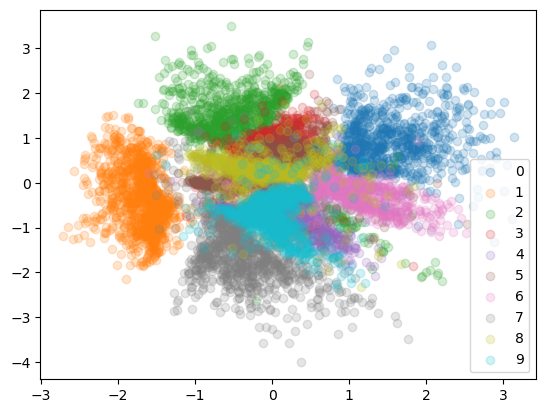


Finished epoch 11 / 50.
Average loss: 478.7222	 Average reconstruction loss: 477.9004	 Average Dkl: 7.6787
Start evaluation loop
Eval beta-vae loss: 491.8994	 Eval reconstruction loss: 478.2033	 Eval Dkl: 6.8481

Finished epoch 12 / 50.
Average loss: 480.0630	 Average reconstruction loss: 477.9169	 Average Dkl: 6.4769
Start evaluation loop
Eval beta-vae loss: 490.3730	 Eval reconstruction loss: 478.0601	 Eval Dkl: 6.1565

Finished epoch 13 / 50.
Average loss: 481.3430	 Average reconstruction loss: 478.0606	 Average Dkl: 5.9241
Start evaluation loop
Eval beta-vae loss: 489.8809	 Eval reconstruction loss: 478.3968	 Eval Dkl: 5.7421

Finished epoch 14 / 50.
Average loss: 482.4624	 Average reconstruction loss: 478.1349	 Average Dkl: 5.5726
Start evaluation loop
Eval beta-vae loss: 489.2117	 Eval reconstruction loss: 478.4311	 Eval Dkl: 5.3903

Finished epoch 15 / 50.
Average loss: 483.4752	 Average reconstruction loss: 478.1690	 Average Dkl: 5.3107
Start evaluation loop
Eval beta-vae loss

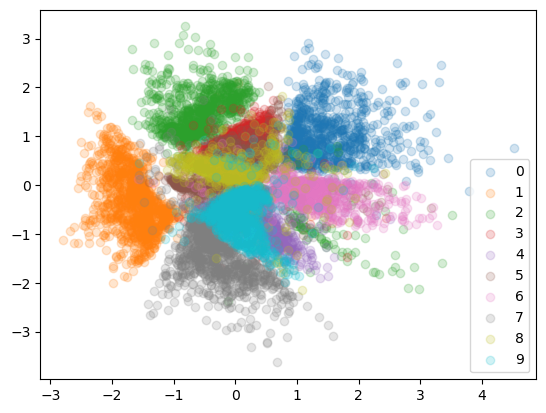


Finished epoch 21 / 50.
Average loss: 477.5211	 Average reconstruction loss: 476.6786	 Average Dkl: 7.8071
Start evaluation loop
Eval beta-vae loss: 491.2501	 Eval reconstruction loss: 477.0447	 Eval Dkl: 7.1027

Finished epoch 22 / 50.
Average loss: 479.0130	 Average reconstruction loss: 476.7995	 Average Dkl: 6.6834
Start evaluation loop
Eval beta-vae loss: 490.1161	 Eval reconstruction loss: 477.3489	 Eval Dkl: 6.3836

Finished epoch 23 / 50.
Average loss: 480.2904	 Average reconstruction loss: 476.8797	 Average Dkl: 6.1554
Start evaluation loop
Eval beta-vae loss: 489.3551	 Eval reconstruction loss: 477.5808	 Eval Dkl: 5.8871

Finished epoch 24 / 50.
Average loss: 481.5598	 Average reconstruction loss: 477.0662	 Average Dkl: 5.7857
Start evaluation loop
Eval beta-vae loss: 488.7261	 Eval reconstruction loss: 477.6318	 Eval Dkl: 5.5472

Finished epoch 25 / 50.
Average loss: 482.7862	 Average reconstruction loss: 477.2919	 Average Dkl: 5.4996
Start evaluation loop
Eval beta-vae loss

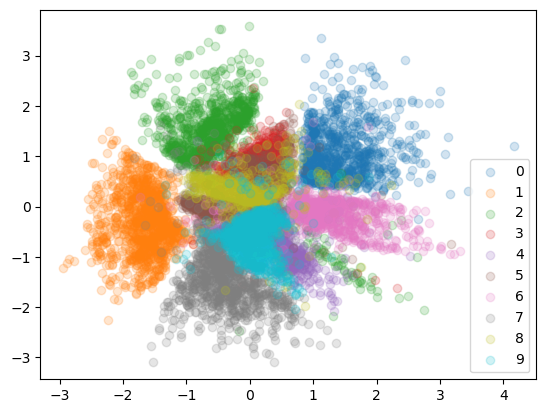


Finished epoch 31 / 50.
Average loss: 476.7764	 Average reconstruction loss: 475.9137	 Average Dkl: 7.9760
Start evaluation loop
Eval beta-vae loss: 491.0122	 Eval reconstruction loss: 476.6213	 Eval Dkl: 7.1955

Finished epoch 32 / 50.
Average loss: 478.2550	 Average reconstruction loss: 475.9912	 Average Dkl: 6.8328
Start evaluation loop
Eval beta-vae loss: 489.5827	 Eval reconstruction loss: 476.7814	 Eval Dkl: 6.4007

Finished epoch 33 / 50.
Average loss: 479.7251	 Average reconstruction loss: 476.2444	 Average Dkl: 6.2806
Start evaluation loop
Eval beta-vae loss: 489.0669	 Eval reconstruction loss: 477.0323	 Eval Dkl: 6.0173

Finished epoch 34 / 50.
Average loss: 481.1228	 Average reconstruction loss: 476.5435	 Average Dkl: 5.8958
Start evaluation loop
Eval beta-vae loss: 488.6459	 Eval reconstruction loss: 477.2133	 Eval Dkl: 5.7163

Finished epoch 35 / 50.
Average loss: 482.4452	 Average reconstruction loss: 476.8294	 Average Dkl: 5.6209
Start evaluation loop
Eval beta-vae loss

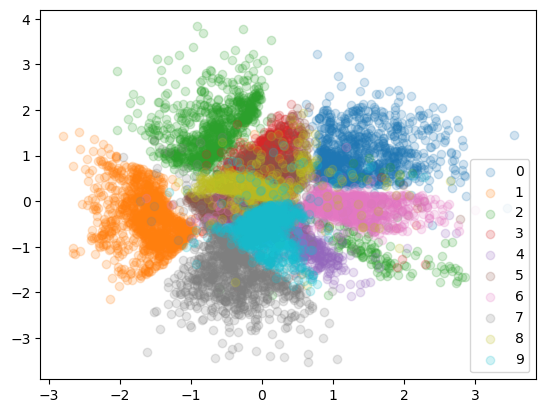


Finished epoch 41 / 50.
Average loss: 476.3716	 Average reconstruction loss: 475.5000	 Average Dkl: 8.0213
Start evaluation loop
Eval beta-vae loss: 490.7529	 Eval reconstruction loss: 476.1895	 Eval Dkl: 7.2817

Finished epoch 42 / 50.
Average loss: 477.8857	 Average reconstruction loss: 475.5918	 Average Dkl: 6.9260
Start evaluation loop
Eval beta-vae loss: 489.4834	 Eval reconstruction loss: 476.4374	 Eval Dkl: 6.5230

Finished epoch 43 / 50.
Average loss: 479.3600	 Average reconstruction loss: 475.8354	 Average Dkl: 6.3612
Start evaluation loop
Eval beta-vae loss: 489.0033	 Eval reconstruction loss: 476.7688	 Eval Dkl: 6.1173

Finished epoch 44 / 50.
Average loss: 480.7817	 Average reconstruction loss: 476.1374	 Average Dkl: 5.9802
Start evaluation loop
Eval beta-vae loss: 488.4237	 Eval reconstruction loss: 477.0499	 Eval Dkl: 5.6869

Finished epoch 45 / 50.
Average loss: 482.0982	 Average reconstruction loss: 476.4005	 Average Dkl: 5.7027
Start evaluation loop
Eval beta-vae loss

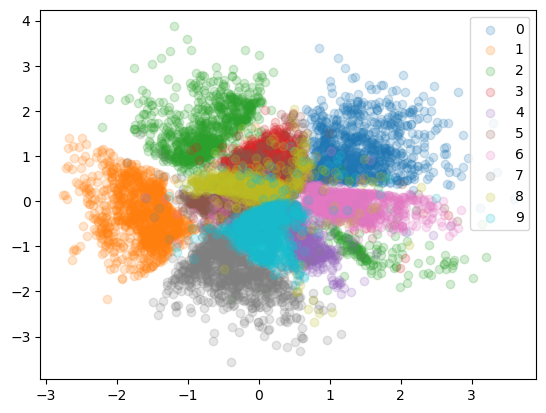


Finished training


VAE(
  (encoder): Encoder(
    (fc_input): Linear(in_features=784, out_features=500, bias=True)
    (fc_hidden): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=2, bias=True)
    (fc_pre_scale): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_hidden1): Linear(in_features=2, out_features=500, bias=True)
    (fc_hidden2): Linear(in_features=500, out_features=500, bias=True)
    (fc_output): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [17]:
latent_dim = 2

beta_vae = VAE(
    latent_dim,
    Encoder(x_dim, hidden_dim, latent_dim),
    Decoder(latent_dim, hidden_dim, (1, 28, 28))
)

beta_vae.to(device=device)

beta_optimizer = torch.optim.Adam(beta_vae.parameters(), lr=lr)
kl_scheduler = CyclicKLScheduler(period=period, maxval=beta, plateau_length=n_batches)


print("Start training")
for epoch in range(1, epochs+1):
    beta_vae.train()
    total_loss = 0
    total_rec = 0
    total_dkl = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        beta_optimizer.zero_grad()

        rec, dkl = beta_vae.compute_losses(batch, *beta_vae(batch))

        loss = rec + kl_scheduler.val * dkl 
        loss.backward()

        beta_optimizer.step()
        kl_scheduler.step()

        total_loss += loss.item()
        total_dkl += dkl.item()
        total_rec += rec.item()
    avg_loss = total_loss / n_batches
    avg_dkl = total_dkl / n_batches 
    avg_rec = total_rec / n_batches
    print(f"Finished epoch {epoch} / {epochs}.\nAverage loss: {avg_loss:.4f}\t Average reconstruction loss: {avg_rec:.4f}\t Average Dkl: {avg_dkl:.4f}")
    print(f"Start evaluation loop")

    beta_vae.eval()
    with torch.no_grad():
        all_mu = []
        all_labels = []
        total_rec = 0
        total_dkl = 0
        for batch, y in test_loader:
            batch = batch.to(device)
            all_labels.append(y)

            dec, enc, z = beta_vae(batch)
            rec, dkl = beta_vae.compute_losses(batch, dec, enc, z)
            all_mu.append(enc.loc.detach().cpu())
            total_rec += rec.item()
            total_dkl += dkl.item()

        avg_rec = total_rec / len(test_loader)
        avg_dkl = total_dkl / len(test_loader)
        avg_loss = avg_rec + kl_scheduler.maxval * avg_dkl
        print(f"Eval beta-vae loss: {avg_loss:.4f}\t Eval reconstruction loss: {avg_rec:.4f}\t Eval Dkl: {avg_dkl:.4f}")
        if epoch % epoch_period == 0:
            all_mu = torch.cat(all_mu, 0).numpy()
            all_labels = torch.cat(all_labels, 0).numpy()
            
            for label in range(10):
                mu_for_label = all_mu[all_labels==label]
                plt.scatter(mu_for_label[:, 0], mu_for_label[:, 1], alpha=.2, label=label)
            plt.legend()
            plt.show()
            del all_mu, all_labels, mu_for_label
        print("")

print("Finished training")
beta_vae.to(cpu)


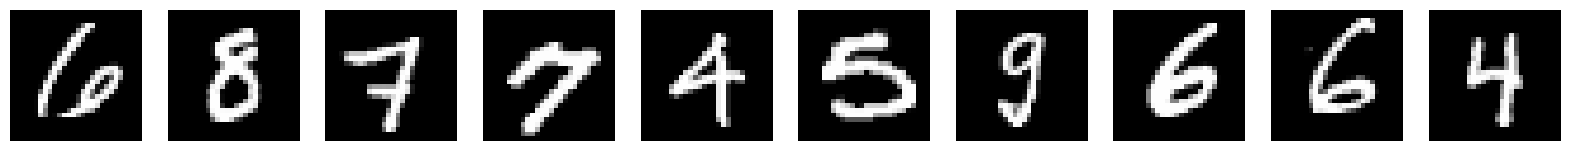

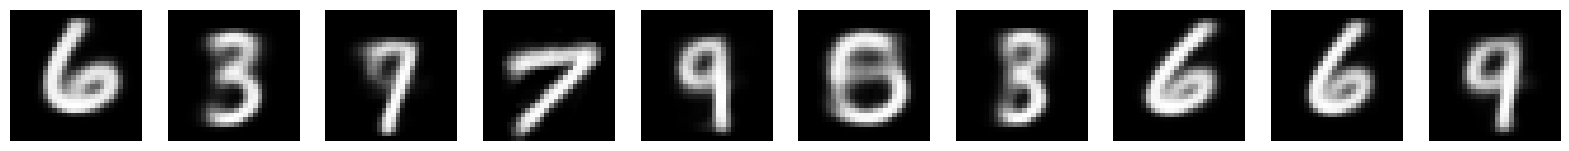

In [18]:
with torch.no_grad():
    batch, _ = next(iter(test_loader))
    reconstructions = beta_vae.auto_encode(batch)
    show_images(batch)
    show_images(reconstructions)

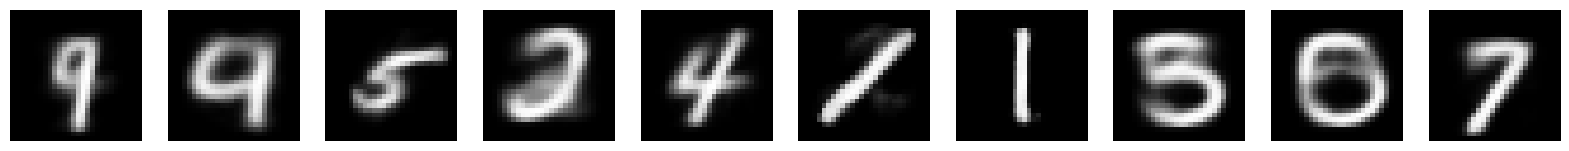

In [19]:
with torch.no_grad():
    show_images(beta_vae.sample(10))